In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
import datetime as dt
import seaborn as sns

In [22]:
df = pd.read_csv("Data/train_clean.csv")
df.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,month_cat,day_cat,new_years_day
0,0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,January,Tuesday,True
1,2,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,January,Tuesday,True
2,3,3,2013-01-01,1,BEVERAGES,0.0,0,Quito,Pichincha,D,13,January,Tuesday,True
3,4,4,2013-01-01,1,BOOKS,0.0,0,Quito,Pichincha,D,13,January,Tuesday,True
4,5,5,2013-01-01,1,BREAD/BAKERY,0.0,0,Quito,Pichincha,D,13,January,Tuesday,True


In [23]:
transactions = pd.read_csv("Data/transactions.csv")
print(transactions.shape)
display(transactions.head())

(83488, 3)


,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [24]:
df = df.merge(transactions, on = ['date', 'store_nbr'], how = 'left')

In [25]:
stores = pd.read_csv("Data/stores.csv")
print(stores.shape)
stores.head()

(54, 5)


,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [26]:
df = pd.merge(df, stores, on = 'store_nbr')
# Change date column to datetime
df['date'] = pd.to_datetime(df['date'])
# Extract additional time-based features
df['day'] = df['date'].dt.day  # 0=Monday, 6=Sunday
df['month'] = df['date'].dt.month  # Extract month as a feature
df['year'] = df['date'].dt.year  # Extract month as a feature
df['day_cat'] = df['date'].dt.day_name() # Create categorical column for day of the week
# Make lagged values for transactions
df["trans_lag"] = df.groupby('store_nbr')['transactions'].shift(1)
df["trans_lag_2"] = df.groupby('store_nbr')['transactions'].shift(2)
df = df.dropna(subset=['trans_lag'])
df = df.dropna(subset=['trans_lag_2'])
# Convert numerical columns to categorical
df["store_nbr"] = df["store_nbr"].astype(str)
# display(df.head())
# df['cluster'] = df['cluster'].astype('category')
# Create combo variable with day of the week and store nbr
df['day_nbr'] = df['day_cat'] +'_'+ df['store_nbr']
# Lets bring in the holidays data in to the mix
holidays = pd.read_csv("Data/holidays_events.csv")
# Change date column to datetime
holidays['date'] = pd.to_datetime(holidays['date'])
# Make column names better
holidays_column_names = ['date', 'holiday_type', 'locale','locale_name', 'holiday_name', 'transferred']
holidays.columns = holidays_column_names
# Choose important Holidays
important_holidays = ['Traslado Batalla de Pichincha','Viernes Santo', 'Carnaval', "Navidad-1", "Navidad-2", "Fundacion de Quito", 
                      "Traslado Primer dia del ano", "Primer dia del ano", "Dia de Difuntos", "Traslado Primer Grito de Independencia",
                      "Puente Dia de Difuntos","Independencia de Cuenca", "Navidad+1"]
holidays = holidays.loc[holidays['holiday_name'].isin(important_holidays)]
# Merge with larger df
df = df.merge(holidays, on ='date', how = "left")
# fill NA with no_holiday to complete categorical variable
df['holiday_name'] = df['holiday_name'].fillna('no_holiday')
df['is_holiday'] = np.where(df['holiday_name'] == 'no_holiday', "not_holiday", "holiday")
df.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,city_x,state_x,type_x,...,year,trans_lag,trans_lag_2,day_nbr,holiday_type,locale,locale_name,holiday_name,transferred,is_holiday
0,564,564,2013-01-01,25,BEVERAGES,810.000,0,Salinas,Santa Elena,D,...,2013,770.0,770.0,Tuesday_25,Holiday,National,Ecuador,Primer dia del ano,False,holiday
1,565,565,2013-01-01,25,BOOKS,0.000,0,Salinas,Santa Elena,D,...,2013,770.0,770.0,Tuesday_25,Holiday,National,Ecuador,Primer dia del ano,False,holiday
2,566,566,2013-01-01,25,BREAD/BAKERY,180.589,0,Salinas,Santa Elena,D,...,2013,770.0,770.0,Tuesday_25,Holiday,National,Ecuador,Primer dia del ano,False,holiday
3,568,568,2013-01-01,25,CLEANING,186.000,0,Salinas,Santa Elena,D,...,2013,770.0,770.0,Tuesday_25,Holiday,National,Ecuador,Primer dia del ano,False,holiday
4,569,569,2013-01-01,25,DAIRY,143.000,0,Salinas,Santa Elena,D,...,2013,770.0,770.0,Tuesday_25,Holiday,National,Ecuador,Primer dia del ano,False,holiday


In [44]:
# df = df.loc[df["store_nbr"].astype(int) <= 3]
# # Lets try this 
# df['store_day_interaction'] = df['store_nbr'].astype(str) + '_' + df['day_cat'].astype(str)
# df['family_day_interaction'] = df['family'].astype(str) + '_' + df['day_cat'].astype(str)
# df['family_store_interaction'] = df['store_nbr'].astype(str) + '_' + df['family'].astype(str)
# df['store_target_enc'] = df.groupby('store_nbr')['sales'].transform('mean')
# df['family_target_enc'] = df.groupby('family')['sales'].transform('mean')
# df['day_target_enc'] = df.groupby('day_cat')['sales'].transform('mean')
# Define the feature matrix (X) and target variable (y)
X = df[["family", "store_nbr", "day_cat", "holiday_name"]]
# One-hot encode categorical columns (drop the first category to avoid multicollinearity)
X = pd.get_dummies(X, drop_first = True)
# Define the target variable
y = np.log1p(df['sales'])
# Display the encoded feature matrix
display(X.head())

,store_target_enc,family_target_enc,day_target_enc,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,...,holiday_name_Navidad+1,holiday_name_Navidad-1,holiday_name_Navidad-2,holiday_name_Primer dia del ano,holiday_name_Puente Dia de Difuntos,holiday_name_Traslado Batalla de Pichincha,holiday_name_Traslado Primer Grito de Independencia,holiday_name_Traslado Primer dia del ano,holiday_name_Viernes Santo,holiday_name_no_holiday
0,243.647217,2591.841582,392.150626,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,243.647217,0.077113,392.150626,False,False,False,True,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,243.647217,503.754760,392.150626,False,False,False,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False
3,243.647217,1165.626593,392.150626,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,False,False
4,243.647217,770.862328,392.150626,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


In [45]:
# Create a TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=3)

# Iterate over the splits
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # display(X_train.head())
    display(X_train.shape)
    display(X_test.shape)
    
    # Train the model
    model = LinearRegression()
    # Train the model with selected features
    model.fit(X_train, y_train)

    # Access the coefficients
    coefficients = model.coef_
    intercept = model.intercept_
    # print("Coefficients:", coefficients)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_pred = np.maximum(y_pred, 0)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

(610984, 107)

(610982, 107)

Mean Squared Error: 0.6099006100207254


(1221966, 107)

(610982, 107)

Mean Squared Error: 0.6262458647653392


(1832948, 107)

(610982, 107)

Mean Squared Error: 0.533076522781606


In [46]:
resid = df.iloc[test_index]
y_pred = pd.DataFrame(y_pred, columns = ["y_pred"]).reset_index(drop = True).set_index(resid.index)
resid = pd.merge(resid, y_pred, left_index=True, right_index=True, how='outer')
resid['residuals'] = resid['transactions'] - resid['y_pred']
resid.head()

,Unnamed: 0,id,date,store_nbr,family,sales,onpromotion,city_x,state_x,type_x,...,holiday_name,transferred,is_holiday,family_store_interaction,family_day_interaction,store_target_enc,family_target_enc,day_target_enc,y_pred,residuals
1832948,2375093,2375093,2016-08-28,5,HOME APPLIANCES,0.0,0,Santo Domingo,Santo Domingo de los Tsachilas,D,...,no_holiday,NaN,not_holiday,5_HOME APPLIANCES,HOME APPLIANCES_Sunday,319.073856,0.497185,568.221263,0.460552,1099.539448
1832949,2375094,2375094,2016-08-28,5,HOME CARE,236.0,5,Santo Domingo,Santo Domingo de los Tsachilas,D,...,no_holiday,NaN,not_holiday,5_HOME CARE,HOME CARE_Sunday,319.073856,297.820308,568.221263,5.695673,1094.304327
1832950,2375095,2375095,2016-08-28,5,LADIESWEAR,13.0,0,Santo Domingo,Santo Domingo de los Tsachilas,D,...,no_holiday,NaN,not_holiday,5_LADIESWEAR,LADIESWEAR_Sunday,319.073856,12.419499,568.221263,1.980505,1098.019495
1832951,2375096,2375096,2016-08-28,5,LAWN AND GARDEN,1.0,0,Santo Domingo,Santo Domingo de los Tsachilas,D,...,no_holiday,NaN,not_holiday,5_LAWN AND GARDEN,LAWN AND GARDEN_Sunday,319.073856,6.567123,568.221263,1.248861,1098.751139
1832952,2375097,2375097,2016-08-28,5,LINGERIE,11.0,0,Santo Domingo,Santo Domingo de los Tsachilas,D,...,no_holiday,NaN,not_holiday,5_LINGERIE,LINGERIE_Sunday,319.073856,7.814093,568.221263,2.001442,1097.998558


In [41]:
# resid.loc[(df['month'] == 12) & (df['year'] == 2016)].set_index('date')[['transactions', 'y_pred']].plot(figsize = (20,8))
# resid.set_index('date')[['transactions', 'y_pred']].plot(figsize = (20,8))

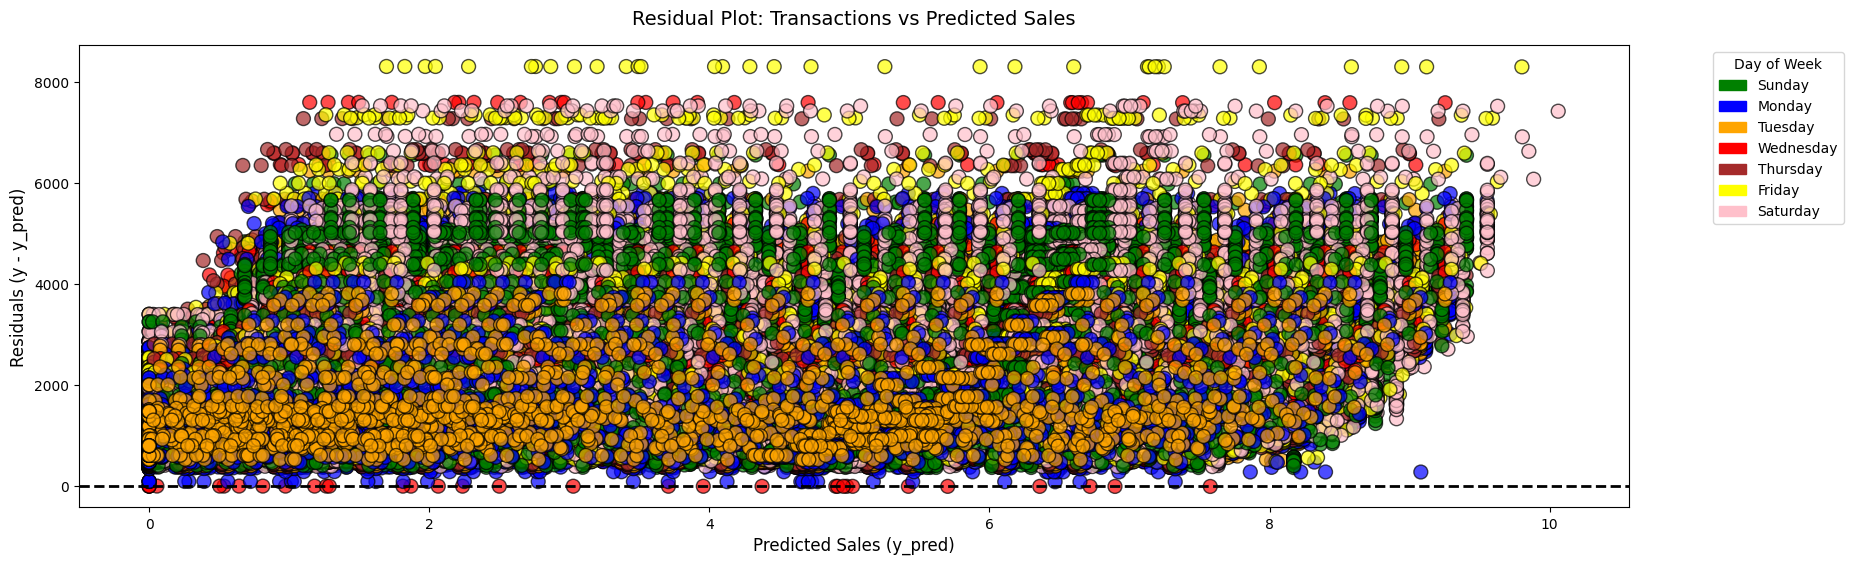

In [47]:
# Plotting
plt.figure(figsize=(20, 6))
# Define color mapping for days
day_colors = {
    'Sunday': 'green', 'Monday': 'blue', 'Tuesday': 'orange',
    'Wednesday': 'red', 'Thursday': 'brown', 'Friday': 'yellow', 'Saturday': 'pink'}
# Scatter plot with two colors based on 'day_cat' (day of the week)
sc = plt.scatter(resid['y_pred'], resid['residuals'], 
                 c=resid['day_cat'].map(day_colors), 
                 s=100, alpha=0.7, edgecolors='k')

# Add a horizontal line at 0 (for residuals)
plt.axhline(0, color='black', lw=2, linestyle='--')

# Labels and title with better spacing
plt.title('Residual Plot: Transactions vs Predicted Sales', fontsize=14, pad=15)
plt.xlabel('Predicted Sales (y_pred)', fontsize=12)
plt.ylabel('Residuals (y - y_pred)', fontsize=12)

# Custom legend
handles = [mpatches.Patch(color=color, label=day) for day, color in day_colors.items()]
plt.legend(handles=handles, title="Day of Week", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()

In [ ]:
state = list(set(resid["state"]))
# Iterate over each store number and plot residuals
for i in state:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["state"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'State {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()

In [ ]:
_type = list(set(resid["type"]))
# Iterate over each store number and plot residuals
for i in _type:
    # Filter the DataFrame for the current store number
    df_filter = resid.loc[resid["type"] == i]
    
    # Plotting
    plt.figure(figsize=(8, 6))
    
    # Scatter plot with two colors based on 'day_cat' (day of the week)
    plt.scatter(df_filter['y_pred'], df_filter['residuals'], 
                c=df_filter['day_cat'].map({'Sunday': 'green', 'Monday': 'blue', 
                                            'Tuesday': 'orange', 'Wednesday': 'red', 
                                            'Thursday': 'brown', 'Friday': 'yellow', 
                                            'Saturday': 'pink'}), s=100)
    
    # Add a horizontal line at 0 (for residuals)
    plt.axhline(0, color='black', lw=2, linestyle='--')
    
    # Add labels and title
    plt.title(f'Type {i} Residual Plot: Transactions vs Predicted Sales')
    plt.xlabel('Predicted Sales (y_pred)')
    plt.ylabel('Residuals (y - y_pred)')
    
    # Show the plot
    plt.show()